<a href="https://colab.research.google.com/github/bpushan/AMPBA_G18/blob/FP2/LSTM_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a LSTM model for stock price prediction.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [4]:
import math
from sklearn.metrics import mean_squared_error

In [5]:
import matplotlib.pyplot as plt

#### URL of the CSV file on GitHub

In [6]:
url = 'https://raw.githubusercontent.com/bpushan/AMPBA_G18/FP2/stock_prc_data.csv'

In [7]:
# Read the CSV file into a DataFrame
stock_prc_data = pd.read_csv(url)

# Display the DataFrame
print(stock_prc_data.head())

                        Date   HDFC_Open  HDFC_Close    HUL_Open   HUL_Close
0  2012-01-02 00:00:00+05:30  193.554086  192.628967  329.679886  325.035370
1  2012-01-03 00:00:00+05:30  194.682296  198.179718  327.337367  329.518280
2  2012-01-04 00:00:00+05:30  199.420686  200.052475  329.235567  319.421509
3  2012-01-05 00:00:00+05:30  200.368400  200.210449  318.977271  317.725281
4  2012-01-06 00:00:00+05:30  199.014582  204.565323  318.048390  320.511993


#### Getting the prices into dataframes by stocks.

In [8]:
HUL = stock_prc_data[['HUL_Close']].reset_index()
# Rename specific columns
HUL.rename(columns={
    'HUL_Close': 'Close'
}, inplace=True)

HUL[:2]

,index,Close
0,0,325.03537
1,1,329.51828


In [9]:
HDFC = stock_prc_data[['HDFC_Close']].reset_index()
# Rename specific columns
HDFC.rename(columns={
    'HDFC_Close': 'Close'
}, inplace=True)

HDFC[:2]

,index,Close
0,0,192.628967
1,1,198.179718


#### Scaling the data with min-max scaling

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
HUL = scaler.fit_transform(np.array(HUL).reshape(-1,1))
HDFC = scaler.fit_transform(np.array(HDFC).reshape(-1,1))

#### Splitting dataset into train (70%) and test (30%) split

In [11]:
training_size = int(len(HDFC)*0.7)
test_size = len(HDFC)-training_size
train_data_HDFC, test_data_HDFC = HDFC[0:training_size,:], HDFC[training_size:len(HDFC),:1]

training_size = int(len(HUL)*0.7)
test_size = len(HUL)-training_size
train_data_HUL, test_data_HUL = HUL[0:training_size,:], HUL[training_size:len(HUL),:1]

In [12]:
print("HDFC train, test: ", train_data_HDFC.shape, test_data_HDFC.shape)
print("HUL train, test: ", train_data_HUL.shape, test_data_HDFC.shape)

HDFC train, test:  (4141, 1) (1775, 1)
HUL train, test:  (4141, 1) (1775, 1)


#### Data needs to be arranged in the form
##### priceday-3, priceday-2 priceday-1 => priceday
##### the number of time to be usedis a hyper parameter here.

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100

In [15]:
X_train_HDFC, y_train_HDFC = create_dataset(train_data_HDFC, time_step)
X_test_HDFC, y_test_HDFC = create_dataset(test_data_HDFC, time_step)

print("HDFC Train Shape: ", X_train_HDFC.shape, y_train_HDFC.shape)
print("HDFC Test Shape: ", X_test_HDFC.shape, y_test_HDFC.shape)

HDFC Train Shape:  (4040, 100) (4040,)
HDFC Test Shape:  (1674, 100) (1674,)


In [16]:
X_train_HUL, y_train_HUL = create_dataset(train_data_HUL, time_step)
X_test_HUL, y_test_HUL = create_dataset(test_data_HUL, time_step)

print("HUL Train Shape: ", X_train_HUL.shape, y_train_HUL.shape)
print("HUL Test Shape: ", X_test_HUL.shape, y_test_HUL.shape)

HUL Train Shape:  (4040, 100) (4040,)
HUL Test Shape:  (1674, 100) (1674,)


#### Reshape input to be [samples, time steps, features] which is required for LSTM

In [17]:
X_train_HDFC =X_train_HDFC.reshape(X_train_HDFC.shape[0],X_train_HDFC.shape[1] , 1)
X_test_HDFC = X_test_HDFC.reshape(X_test_HDFC.shape[0],X_test_HDFC.shape[1] , 1)

In [18]:
X_train_HUL =X_train_HUL.reshape(X_train_HUL.shape[0],X_train_HUL.shape[1] , 1)
X_test_HUL = X_test_HUL.reshape(X_test_HUL.shape[0],X_test_HUL.shape[1] , 1)

### Create the Stacked LSTM model.

In [19]:
model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           30200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 91251 (356.45 KB)
Trainable params: 91251 (356.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.fit(X_train_HDFC,y_train_HDFC,validation_data=(X_test_HDFC,y_test_HDFC),epochs=25,batch_size=64,verbose=1)

Epoch 1/25
64/64 [==============================] - 9s 33ms/step - loss: 0.0143 - val_loss: 0.0366
Epoch 2/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0363
Epoch 3/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0081 - val_loss: 0.0362
Epoch 4/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0084 - val_loss: 0.0355
Epoch 5/25
64/64 [==============================] - 1s 22ms/step - loss: 0.0085 - val_loss: 0.0469
Epoch 6/25
64/64 [==============================] - 1s 23ms/step - loss: 0.0086 - val_loss: 0.0398
Epoch 7/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0086 - val_loss: 0.0377
Epoch 8/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0371
Epoch 9/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0370
Epoch 10/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0350
Epoch 11/

#### Lets Do the prediction and check performance metrics

In [22]:
train_predict=model.predict(X_train_HDFC)
test_predict=model.predict(X_test_HDFC)

53/53 [==============================] - 0s 6ms/step


####Transformback to original form

In [23]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

#### Calculate RMSE performance metrics

In [24]:
math.sqrt(mean_squared_error(y_train_HDFC,train_predict))

1004.5028013795949

#### Test Data RMSE

In [25]:
math.sqrt(mean_squared_error(y_test_HDFC,test_predict))

2028.043958344609

#### Calculate MAPE
Mean Absolute Percentage Error (MAPE) is a popular metric for evaluating the accuracy of predictions in time series forecasting. MAPE measures the accuracy of a model by calculating the absolute percentage error between the predicted and actual values.

In [30]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
train_MAPE = calculate_mape(y_train_HDFC,train_predict)
print(train_MAPE)

496262.1970578729


In [29]:
test_MAPE = calculate_mape(y_test_HDFC,test_predict)
print(test_MAPE)

316347.5192860445


#### Predict for HDFC.

In [31]:
len(test_data_HDFC)

1775

In [32]:
x_input=test_data_HDFC[1675:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

#### Predicting for next 200 days.

In [34]:
HDFC_output=[]
n_steps=100
i=0
while(i <= 200):

    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        HDFC_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        HDFC_output.extend(yhat.tolist())
        i=i+1


print(HDFC_output)

[0.9414905]
101
[[0.9414904713630676], [0.5664094090461731], [0.9302598834037781], [0.5755109786987305], [0.9156607985496521], [0.5811201333999634], [0.9009785652160645], [0.5852128863334656], [0.8869573473930359], [0.588413655757904], [0.8737754225730896], [0.5910006165504456], [0.8614467978477478], [0.5931296944618225], [0.8499286770820618], [0.5949011445045471], [0.8391596078872681], [0.5963859558105469], [0.8290743827819824], [0.5976361036300659], [0.8196110725402832], [0.5986909866333008], [0.8107138276100159], [0.5995815992355347], [0.8023325800895691], [0.6003329157829285], [0.7944236993789673], [0.6009648442268372], [0.7869484424591064], [0.6014940142631531], [0.7798727750778198], [0.6019346714019775], [0.7731661796569824], [0.6022986173629761], [0.7668012380599976], [0.60259610414505], [0.7607536911964417], [0.6028355360031128], [0.7550011277198792], [0.6030248403549194], [0.7495235204696655], [0.6031701564788818], [0.7443028092384338], [0.6032772660255432], [0.739322006702423

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,302)

In [36]:
print(len(HDFC))
print(len(HDFC_output))

5916
201


In [37]:
HDFC[:5]

array([[0.        ],
       [0.06514338],
       [0.00033818],
       [0.06702053],
       [0.00067636]])

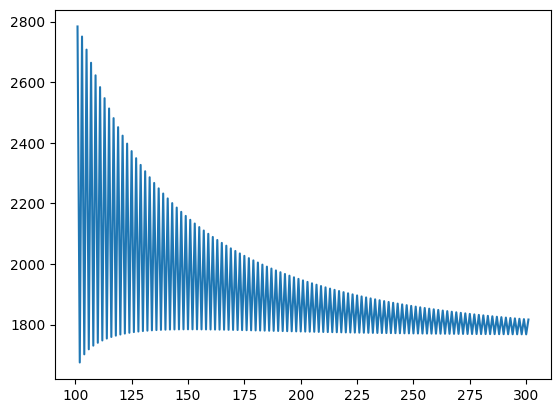

In [38]:
#plt.plot(day_new,scaler.inverse_transform(HDFC[5816:]))
plt.plot(day_pred,scaler.inverse_transform(HDFC_output))

In [39]:
HDFC_Pred = scaler.inverse_transform(HDFC_output).tolist()

#### Now Create the Model for HUL.

In [46]:
model_HUL=Sequential()
model_HUL.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model_HUL.add(LSTM(50,return_sequences=True))
model_HUL.add(LSTM(50))
model_HUL.add(Dense(1))
model_HUL.compile(loss='mean_squared_error',optimizer='adam')

In [47]:
model_HUL.fit(X_train_HUL,y_train_HUL,validation_data=(X_test_HUL,y_test_HUL),epochs=25,batch_size=64,verbose=1)

Epoch 1/25
64/64 [==============================] - 7s 49ms/step - loss: 0.0098 - val_loss: 0.0026
Epoch 2/25
64/64 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 3/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 4/25
64/64 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 5/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 6/25
64/64 [==============================] - 1s 17ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 7/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 8/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 9/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 10/25
64/64 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 11/

In [48]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train_HUL)
test_predict=model.predict(X_test_HUL)

53/53 [==============================] - 0s 6ms/step


In [49]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [50]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train_HUL,train_predict))

1145.875511854515

In [51]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test_HUL,test_predict))

2276.8057636391577

In [52]:
train_MAPE = calculate_mape(y_train_HUL,train_predict)
print(train_MAPE)

482911.47316886275


In [53]:
test_MAPE = calculate_mape(y_test_HUL,test_predict)
print(test_MAPE)

277998.38937992026


In [54]:
len(test_data_HUL)

1775

In [55]:
x_input=test_data_HUL[1675:].reshape(1,-1)
x_input.shape

(1, 100)

In [56]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [57]:
# demonstrate prediction for next 200 days

HUL_output=[]
n_steps=100
i=0
while(i<= 200):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        HUL_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        HUL_output.extend(yhat.tolist())
        i=i+1


print(HUL_output)

[0.8816977]
101
[[0.8816977143287659], [0.8267337679862976], [0.8805052638053894], [0.8257988691329956], [0.8696926832199097], [0.8179668188095093], [0.8565307259559631], [0.8085416555404663], [0.8432875871658325], [0.7989046573638916], [0.8306409120559692], [0.7895355224609375], [0.8187901973724365], [0.7806137800216675], [0.8077671527862549], [0.7722001075744629], [0.7975385785102844], [0.7643002867698669], [0.7880464196205139], [0.7568945288658142], [0.7792256474494934], [0.7499520182609558], [0.7710133790969849], [0.7434378266334534], [0.7633505463600159], [0.7373183965682983], [0.7561850547790527], [0.731561005115509], [0.7494706511497498], [0.7261366248130798], [0.7431662678718567], [0.7210185527801514], [0.7372363805770874], [0.7161827087402344], [0.7316491007804871], [0.7116075158119202], [0.7263765335083008], [0.7072734832763672], [0.7213934063911438], [0.7031627297401428], [0.7166774272918701], [0.6992596983909607], [0.7122081518173218], [0.6955500245094299], [0.7079675793647

In [58]:
day_new=np.arange(1,101)
day_pred=np.arange(101,302)

In [59]:
print(len(HUL))
print(len(HUL_output))

5916
201


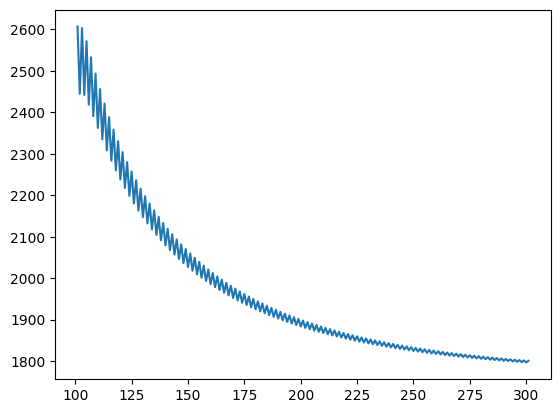

In [60]:
#plt.plot(day_new,scaler.inverse_transform(HUL[5816:]))
plt.plot(day_pred,scaler.inverse_transform(HUL_output))

In [61]:
HUL_Pred = scaler.inverse_transform(HUL_output).tolist()

In [62]:
Preds = {
    'HDFC Bank': HDFC_Pred,
    'Hindustan Uniliver': HUL_Pred
}
Pred_df = pd.DataFrame(Preds)

## Write the Prediction file to GDrive

In [63]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define the output file path in Google Drive
output_file_path = '/content/drive/My Drive/Stock_Prediction.csv'

# Write the DataFrame to a CSV file in Google Drive
Pred_df.to_csv(output_file_path, index=False)

Mounted at /content/drive
